# Use Case: Synthetize Data for Image-Text Datasets.

This notebook demonstrates how to use some Data-Juicer OPs to synthetize new dataset from a given seed dataset.

Synthetize new data is like replacing the old contents of samples with newly synthetic ones, so we use Mappers to acheive this goal.

Specifically, we will take `image_captioning_mapper` and `image_diffusion_mapper` as example OPs. The former one, `image_captioning_mapper`, generate new captions for images in each sample, and the latter one, `image_diffusion_mapper`, generate new images or edit contents of existing images according to their captions. These two OPs are empowered by some excellent models, such as BLIP-2 and Stable Diffusion. Users are allowed to replace with other models. More details about these two OPs can be found in the [config_all.yaml](https://github.com/modelscope/data-juicer/blob/feat/tutorials/configs/config_all.yaml) file and their corresponding code implementations.

Now, let's begin the synthesis process to get a new dataset.

## Dataset Preparation

Here we only consider a example dataset of two image-text pair samples. We write it to a `jsonl` file first.

The intermediate format of multimodal datasets in Data-Juicer is defined [here](https://github.com/modelscope/data-juicer/blob/main/tools/multimodal/README.md).

In [1]:
import jsonlines as jl

ds = [
    {
        'text': '<__dj__image> a picture of prince and princess kate\'s mugs in a frame',
        'images': ['imgs/img1.png'],
    },
    {
        'text': 'the setting sun in africa on a cloudy day stock photo © monkeypox <__dj__image>',
        'images': ['imgs/img2.png'],
    }
]

with jl.open('ds.jsonl', 'w') as writer:
    writer.write_all(ds)

And we download these two example images to `./imgs`.

In [2]:
!mkdir -p imgs && wget http://dail-wlcb.oss-cn-wulanchabu.aliyuncs.com/data_juicer/tutorial_data/img1.png -O ./imgs/img1.png && wget http://dail-wlcb.oss-cn-wulanchabu.aliyuncs.com/data_juicer/tutorial_data/img2.png -O ./imgs/img2.png

--2024-08-12 12:21:05--  http://dail-wlcb.oss-cn-wulanchabu.aliyuncs.com/data_juicer/tutorial_data/img1.png
Resolving dail-wlcb.oss-cn-wulanchabu.aliyuncs.com (dail-wlcb.oss-cn-wulanchabu.aliyuncs.com)... 39.101.35.6
Connecting to dail-wlcb.oss-cn-wulanchabu.aliyuncs.com (dail-wlcb.oss-cn-wulanchabu.aliyuncs.com)|39.101.35.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 232261 (227K) [image/png]
Saving to: ‘./imgs/img1.png’

./imgs/img1.png     100%[===================>] 226.82K  --.-KB/s    in 0.1s    

2024-08-12 12:21:05 (2.10 MB/s) - ‘./imgs/img1.png’ saved [232261/232261]

--2024-08-12 12:21:05--  http://dail-wlcb.oss-cn-wulanchabu.aliyuncs.com/data_juicer/tutorial_data/img2.png
Resolving dail-wlcb.oss-cn-wulanchabu.aliyuncs.com (dail-wlcb.oss-cn-wulanchabu.aliyuncs.com)... 39.101.35.6
Connecting to dail-wlcb.oss-cn-wulanchabu.aliyuncs.com (dail-wlcb.oss-cn-wulanchabu.aliyuncs.com)|39.101.35.6|:80... connected.
HTTP request sent, awaiting response... 200

### Visualization of Images

We can also prepare a function to visualize the sample in the dataset.

<__dj__image> a picture of prince and princess kate's mugs in a frame


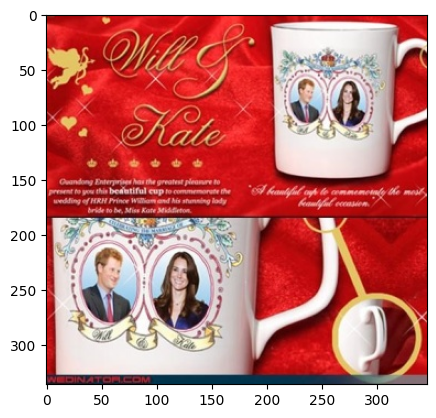

the setting sun in africa on a cloudy day stock photo © monkeypox <__dj__image>


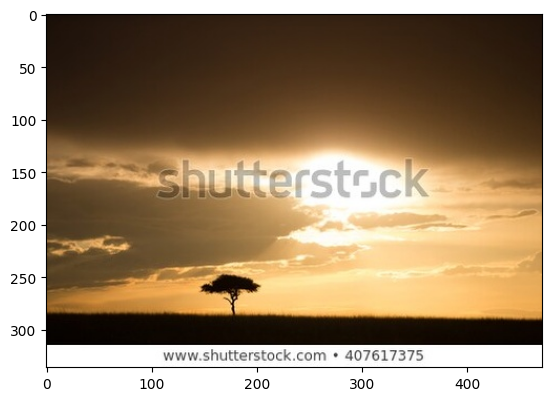

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
def vis(s):
    print(s['text'])
    img = Image.open(s['images'][0])
    plt.imshow(np.asarray(img))
    plt.show()

for s in ds:
    vis(s)

## Image Recaptioning

We can recaption an image with OP `image_captioning_mapper`. First we need to create a data recipe for this process.

In [3]:
recipe = '''
dataset_path: ds.jsonl
export_path: outputs/image_captioning_output/res.jsonl

process:
  - image_captioning_mapper:
      hf_img2seq: 'Salesforce/blip2-opt-2.7b'  # You can replace this path to a local downloaded HF model
      keep_original_sample: false  # we only need the recaptioned captions
'''

with open('image_captioning.yaml', 'w') as fout:
    fout.write(recipe)

Then we can run the process program of Data-Juicer to process the dataset.

In [4]:
!dj-process --config image_captioning.yaml

2024-07-26 04:20:27.194 | INFO     | data_juicer:setup_mp:67 - Setting multiprocess start method to 'forkserver'.
2024-07-26 04:20:34 | INFO     | data_juicer.config.config:646 - Back up the input config file [/mnt/workspace/lielin.hyl/dj_synth_test/tutorials/image_captioning.yaml] into the work_dir [/mnt/workspace/lielin.hyl/dj_synth_test/tutorials/outputs/image_captioning_output]
2024-07-26 04:20:34 | INFO     | data_juicer.config.config:668 - Configuration table: 
╒════════════════════════════╤════════════════════════════════════════════════════════════════════════════════════════════════╕
│ key                        │ values                                                                                         │
╞════════════════════════════╪════════════════════════════════════════════════════════════════════════════════════════════════╡
│ config                     │ [Path_fr(image_captioning.yaml, cwd=/mnt/workspace/lielin.hyl/dj_synth_test/tutorials)]        │
├───────────────

We can read the result dataset to check the differences before and after recaptioning.

<__dj__image> the royal wedding mug is shown on red background
 <|__dj__eoc|>


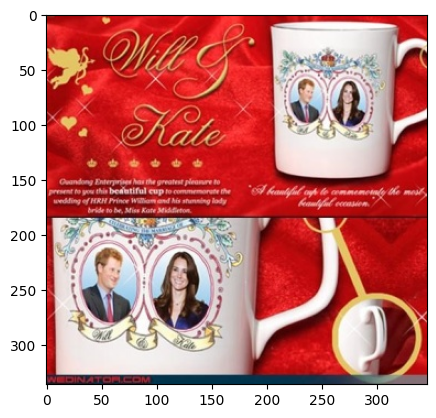

<__dj__image> lone lone acacia against a dramatic sunrise in africa
 <|__dj__eoc|>


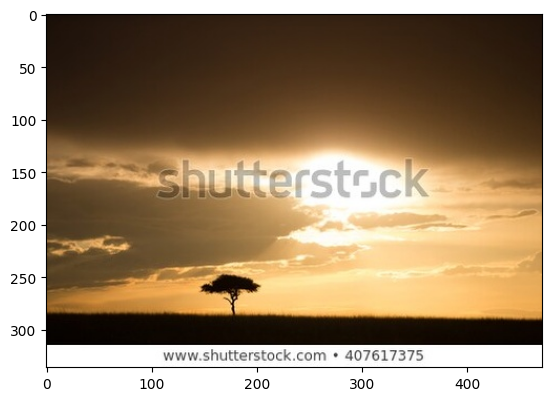

In [5]:
with jl.open('outputs/image_captioning_output/res.jsonl') as reader:
    for s in reader:
        vis(s)

As we can see, this OP recaption these two images, remove some noisy information from the texts and add some details to tem to improve their quality, such as adding "red background" and removing "© monkeypox". It suggests that recaption the images with more excellent models could synthesize better image-text samples with better cross-modality alignment.

Captioning is a big topic. Data-Juicer provides many other OPs to give captions from various perspectives with more state-of-the-art models.

## Image Synthesis

We can generate a new image or edit the content of the original image with OP `image_diffusion_mapper`. Similarly, we need to create a data recipe for this process.

In [6]:
recipe = '''
dataset_path: ds.jsonl
export_path: outputs/image_diffusion_output/res.jsonl

process:
  - image_diffusion_mapper:
      hf_diffusion: 'CompVis/stable-diffusion-v1-4'  # You can replace this path to a local downloaded HF model
      keep_original_sample: false  # we only need the recaptioned captions
      caption_key: 'text'
'''

with open('image_diffusion.yaml', 'w') as fout:
    fout.write(recipe)

Then we can run the process program of Data-Juicer to process the dataset.

In [7]:
!dj-process --config image_diffusion.yaml

2024-07-26 04:22:31.685 | INFO     | data_juicer:setup_mp:67 - Setting multiprocess start method to 'forkserver'.
2024-07-26 04:22:39 | INFO     | data_juicer.config.config:646 - Back up the input config file [/mnt/workspace/lielin.hyl/dj_synth_test/tutorials/image_diffusion.yaml] into the work_dir [/mnt/workspace/lielin.hyl/dj_synth_test/tutorials/outputs/image_diffusion_output]
2024-07-26 04:22:39 | INFO     | data_juicer.config.config:668 - Configuration table: 
╒════════════════════════════╤════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ key                        │ values                                                                                                 │
╞════════════════════════════╪════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ config                     │ [Path_fr(image_diffusion.yaml, cwd=/mnt/workspace/lielin.hyl/dj_synth_test/tutorials)]     

We can read the result dataset to check the differences before and after synthesis.

<__dj__image> a picture of prince and princess kate's mugs in a frame


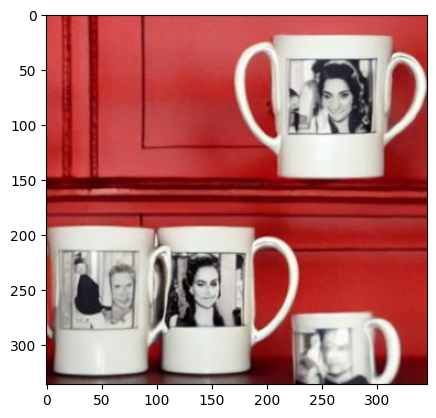

the setting sun in africa on a cloudy day stock photo © monkeypox <__dj__image>


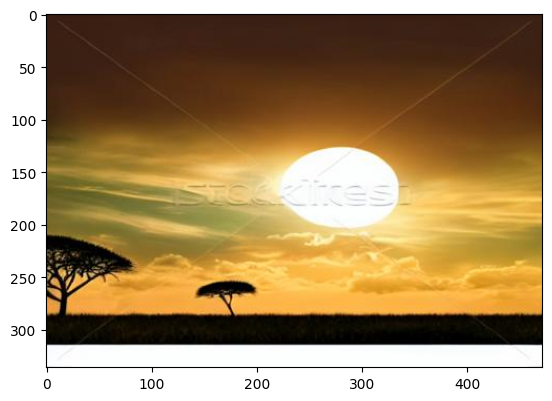

In [9]:
with jl.open('outputs/image_diffusion_output/res.jsonl') as reader:
    for s in reader:
        vis(s)

As we can see, this OP synthesize new images for this two captions, also try to remove extra and noisy vision information from the images. For example, most texts and watermarks from both synthsized images are removed, and the conceptions of "mugs" and "sun" in these two images are enhanced. Therefore, these two synthesized images can be considered useful for training of modality alignment.

# Conclusion

In this notebook, we learn how to synthesize new samples with Data-Juicer OPs through a use case on image-text datasets and check their quality changes in the synthesized results.